# Dynamic Time Warping

(This notebook is based on the Python Notebooks from Meinard Müller's [Fundamentals of Music Processing](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html) book.)

Dynamic time warping (DWT) is a dynamic programming algorithm to find the **optimal** alignment between to time-dependent sequences.

In this notebook we will explore how this algorithm works.

## Features, Feature Spaces

Let us consider two $\mathbf{X} = \{\mathbf{x}_1, \dots \mathbf{x}_N\}$ and $\mathbf{Y} = \{\mathbf{y}_1, \dots, \mathbf{y}_M\}$ for which we want to find an aligment.

* This sequences could be discrete signals, feature sequences, sequences of characters, etc.

* The elements $\mathbf{x}_n$, $\mathbf{y}_m$ belong to the same **feature space** $\mathcal{F}$. For the purposes of this class, let us consider these elements as $K$-dimensional real-vectors, i.e., $\mathbf{x}, \mathbf{y} \in \mathbb{R}^K$ although they can other kind of objects (e.g., characters in an alphabet).

An important aspect of this feature space is that it allows us to use *quantitive measures* of how similar the elements of sequence $\mathbf{X}$ are to the elements in sequence $\mathbf{Y}$. We will come to this point in a moment.

For now, let us generate some test data that we can play with!

In [1]:
import numpy as np
from helper import generate_example_sequences
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


(0.0, 33.0)

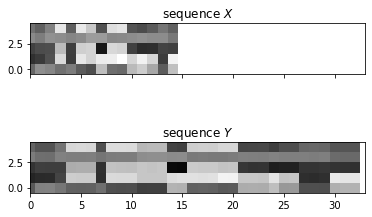

In [2]:
# This is a helper method to generate sample sequences 
# (see helper.py for documentation)

lenX = 15
X, Y, gr_path = generate_example_sequences(lenX=lenX, centers=3, n_features=5,
                               maxreps=4, minreps=1, noise_scale=0.1)

# Let us plot the data to see how it looks like!
vmax = max(max(abs(X.max()), abs(X.min())), max(abs(Y.max()), abs(Y.min())))
fig, axes = plt.subplots(2, sharex=True)
axes[0].imshow(X.T, cmap='gray', origin='lower', 
               aspect='equal', interpolation=None, 
               vmax=vmax, vmin=-vmax)
axes[0].set_title("sequence $X$")
axes[1].imshow(Y.T, cmap='gray', origin='lower', aspect='equal', 
               interpolation=None, vmax=vmax, vmin=-vmax)
axes[1].set_title("sequence $Y$")
axes[0].set_xlim((0, len(Y)))
axes[1].set_xlim((0, len(Y)))

## Comparing the similarity of the features: Local cost distance

As mentioned before, we would like to know how to compare the elements in $\mathbf{X}$ and $\mathbf{Y}$. For this we use a local distance function, which can be any distance(-like) function that is small when $\mathbf{x}_i$ is *similar* to $\mathbf{y}_j$.

Which distance to use depends on the problem at hand, although usual starting points are the Euclidean and the Manhattan ($L_1$) distances.

Using this local distance, we can compare the elements in both sequences by comparing the pairwise distance of all elements in $\mathbf{X}$ and $\mathbf{Y}$. This will result in a matrix $\mathbf{C}$, where the element $c_{ij}$ is given by

$$c_{ij} = \text{distance}(\mathbf{x}_i, \mathbf{y}_j)$$

In [3]:
def pairwise_distance_matrix(X, Y, metric='euclidean'):
    """
    Compute pairwise distance matrix of two sequences
    
    Parameters
    ----------
    X : np.ndarray
        A 2D array with size (n_observations, n_features)
    Y : np.ndarray
        A 2D array with size (m_observations, n_features)
    metric: str
        A string defining a metric (see possibilities 
        in scipy.spatial.distance.cdist)

    Returns
    -------
    C : np.ndarray
        Pairwise cost matrix
    """
    if X.ndim == 1:
        X, Y = np.atleast_2d(X, Y)
        X = X.T
        Y = Y.T
    C = cdist(X, Y, metric=metric)
    return C

Text(0, 0.5, 'Sequence X')

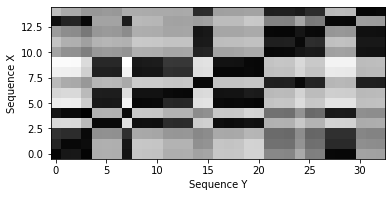

In [4]:
# Visualize cost matrix
C = pairwise_distance_matrix(X, Y)
plt.imshow(C, origin='lower', aspect='equal', cmap='gray')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

Text(0, 0.5, 'Sequence X')

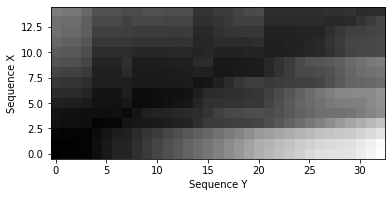

In [5]:
def accumulated_cost_matrix(C):
    """
    Dynamic time warping cost matrix from a pairwise distance matrix

    Parameters
    ----------
    D : double array
        Pairwise distance matrix (computed e.g., with `cdist`).

    Returns
    -------
    D : np.ndarray
        Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D = accumulated_cost_matrix(C) 

# Visualize accumulated cost matrix
plt.imshow(D, origin='lower', aspect='equal', cmap='gray')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

In [6]:
def optimal_warping_path(D):
    """
    Compute the warping path given an accumulated cost matrix

    Parameters
    ----------
    D: np.ndarray
        Accumulated cost Matrix
    
    Returns
    -------
    P: np.ndarray
        Optimal warping path
    """
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    return np.array(P)
        
P = optimal_warping_path(D)


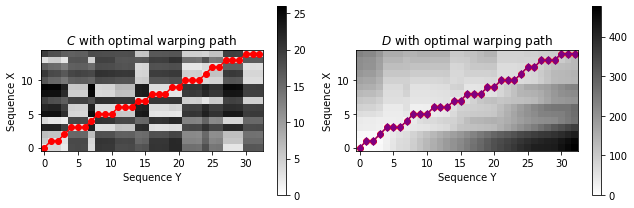

In [7]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.plot(gr_path[:, 1], gr_path[:, 0], marker='d', color='purple', linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()


But of course, this is a very slow implementation of the algorithm!

Let's put everything together into a single function

In [8]:
def dynamic_time_warping(X, Y, metric='euclidean'):
    """
    Naive Implementation of Vanilla Dynamic Time Warping
    
    Parameters
    ----------
    X : np.ndarray
        Array X
    Y: np.ndarray
        Array Y
    metric: string
        Scipy Metric
    """
    # Compute pairwise distance matrix
    C = pairwise_distance_matrix(X, Y, metric=metric)
    # Compute accumulated cost matrix
    D = accumulated_cost_matrix(C)
    dtwd = D[-1, -1]
    warping_path = optimal_warping_path(D)
    return warping_path, dtwd

For reference, in `dtw.py` there is a faster implementation of DTW using Cython.

In [9]:
from dtw import dynamic_time_warping as cy_dtw
import time

def time_function(func, **kwargs):
    start = time.time()
    output = func(**kwargs)
    return time.time() - start, output

n_comparisons = 10
time_comparison = np.zeros((n_comparisons, 2))
for i in range(n_comparisons):
    X, Y, _ = generate_example_sequences(100)
    kwargs = dict(X=X, Y=Y)
    time_naive_dtw, (n_path, n_dtwd) = time_function(dynamic_time_warping, **kwargs)
    time_cy_dtw, (c_path, c_dtwd) = time_function(cy_dtw, **kwargs)
    
    time_comparison[i] = (time_naive_dtw, time_cy_dtw)
    assert(c_dtwd == n_dtwd)
    
print(f"Average Time naive DTW: {time_comparison[:, 0].mean():.4f}")
print(f"Average Time cython DTW: {time_comparison[:, 1].mean():.4f}!")


Average Time naive DTW: 0.0196
Average Time cython DTW: 0.0029!
